In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging, sys
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, GRU

2024-04-14 11:36:36.611508: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 11:36:36.614133: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 11:36:36.643535: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 11:36:37.310894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_csv('./Google_Stock_Price_Train.csv')

In [4]:
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',drop=True,inplace=True)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float)
df['Close'] = df['Close'].str.replace(',', '').astype(float)

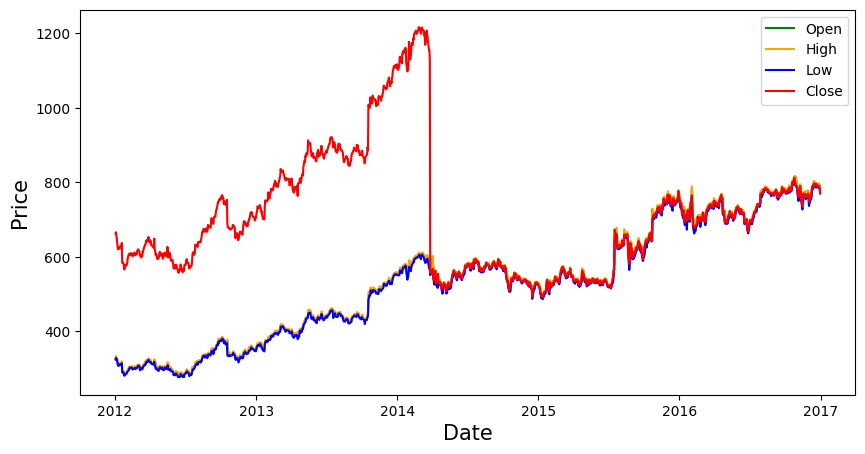

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df['Open'], label='Open', color='green')
ax.plot(df['High'], label='High', color='orange')
ax.plot(df['Low'],label='Low',color='blue')
ax.plot(df['Close'],label='Close',color='red')
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Price',size=15)
ax.legend()

fig.show()

In [6]:
df['Close'] = df.apply(lambda x: x['Close']/2 if x['Close'] > x['High'] else x['Close'], axis=1)

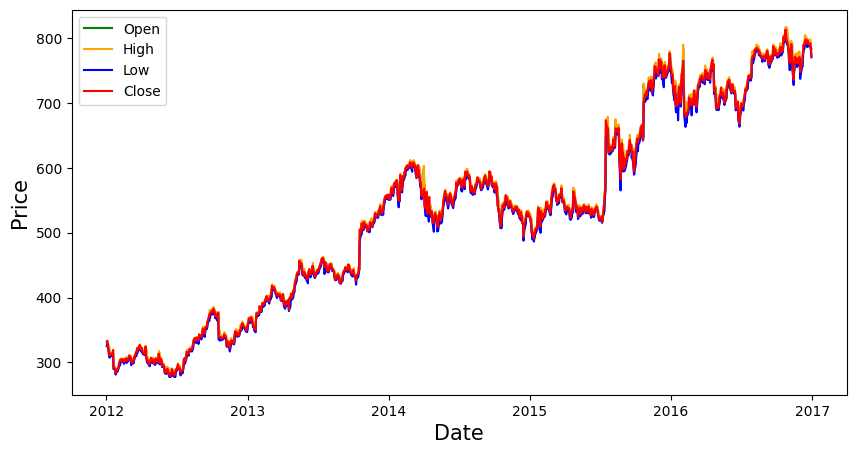

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df['Open'], label='Open', color='green')
ax.plot(df['High'], label='High', color='orange')
ax.plot(df['Low'],label='Low',color='blue')
ax.plot(df['Close'],label='Close',color='red')
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Price',size=15)
ax.legend()

fig.show()

In [8]:
predictors = ['Close']

# Drop all columns except predictors
df = df[predictors]

In [9]:
def create_sequence(dataset):
    sequences = []
    labels = []
    for i in range(len(dataset) - 10):  # Loop until 10 elements from the end
        sequences.append(dataset[i:i+10])
        labels.append(dataset[i+10])
    return np.array(sequences), np.array(labels)

In [10]:
SS = StandardScaler()
df[df.columns] = SS.fit_transform(df)

# Split data into train, validation, and test sets
split_data = np.split(df, [int(.7*len(df)), int(.85*len(df))])
# Convert data splits into NumPy arrays
train_x_rnn, valid_x_rnn, test_x_rnn = [d[predictors].to_numpy() for d in split_data]

train_seq_rnn, train_label_rnn = create_sequence(train_x_rnn)
valid_seq_rnn, valid_label_rnn = create_sequence(valid_x_rnn)
test_seq_rnn, test_label_rnn = create_sequence(test_x_rnn)
train_seq_rnn.shape, train_label_rnn.shape, valid_seq_rnn.shape, valid_label_rnn.shape, test_seq_rnn.shape, test_label_rnn.shape

((870, 10, 1), (870, 1), (179, 10, 1), (179, 1), (179, 10, 1), (179, 1))

In [11]:
RNNmodel = Sequential()
RNNmodel.add(SimpleRNN(20, 
                           input_shape = (train_seq_rnn.shape[1], train_seq_rnn.shape[2])))

RNNmodel.add(Dropout(0.1)) 
RNNmodel.add(Dense(1))
RNNmodel.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

RNNmodel.summary()

2024-04-14 11:36:38.110765: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-14 11:36:38.111218: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461 (1.80 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
RNNhistory = RNNmodel.fit(train_seq_rnn, train_label_rnn, epochs=50,validation_data=(valid_seq_rnn, valid_label_rnn), verbose=1)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3742 - mean_absolute_error: 1.1692 - val_loss: 1.1026 - val_mean_absolute_error: 0.9332
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3543 - mean_absolute_error: 0.4347 - val_loss: 0.3469 - val_mean_absolute_error: 0.4928
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1281 - mean_absolute_error: 0.2823 - val_loss: 0.2598 - val_mean_absolute_error: 0.4298
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0724 - mean_absolute_error: 0.1974 - val_loss: 0.2074 - val_mean_absolute_error: 0.3929
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0450 - mean_absolute_error: 0.1532 - val_loss: 0.1562 - val_mean_absolute_error: 0.3419
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0334 - mean_absolute_error: 0.1350 - val_loss: 0.1327 - val_mean_absolute_error: 0.3177
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0301 - mean_absolute_error: 0.1261 - val_loss: 0.119

Epoch 46/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0100 - mean_absolute_error: 0.0734 - val_loss: 0.0267 - val_mean_absolute_error: 0.1339
Epoch 47/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - mean_absolute_error: 0.0705 - val_loss: 0.0296 - val_mean_absolute_error: 0.1428
Epoch 48/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - mean_absolute_error: 0.0732 - val_loss: 0.0268 - val_mean_absolute_error: 0.1346
Epoch 49/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0705 - val_loss: 0.0323 - val_mean_absolute_error: 0.1509
Epoch 50/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0079 - mean_absolute_error: 0.0669 - val_loss: 0.0266 - val_mean_absolute_error: 0.1341


In [13]:
MMS = MinMaxScaler()
df[df.columns] = MMS.fit_transform(df)

# Split data into train, validation, and test sets
split_data = np.split(df, [int(.7*len(df)), int(.85*len(df))])
# Convert data splits into NumPy arrays
train_x_gru, valid_x_gru, test_x_gru = [d[predictors].to_numpy() for d in split_data]

train_seq_gru, train_label_gru = create_sequence(train_x_gru)
valid_seq_gru, valid_label_gru = create_sequence(valid_x_gru)
test_seq_gru, test_label_gru = create_sequence(test_x_gru)
train_seq_gru.shape, train_label_gru.shape, valid_seq_gru.shape, valid_label_gru.shape, test_seq_gru.shape, test_label_gru.shape

((870, 10, 1), (870, 1), (179, 10, 1), (179, 1), (179, 10, 1), (179, 1))

In [14]:
GRUmodel = Sequential()

GRUmodel.add(GRU(30,
                     activation = "tanh",
                     recurrent_activation = "sigmoid",
                     input_shape=(train_seq_gru.shape[1], train_seq_gru.shape[2])))

GRUmodel.add(Dropout(rate=0.1))
GRUmodel.add(Dense(1))
GRUmodel.compile(loss='mean_squared_error', optimizer = 'adam')

GRUmodel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30)             │         2,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,001 (11.72 KB)

 Trainable params: 3,001 (11.72 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
GRUhistory = GRUmodel.fit(train_seq_gru, train_label_gru, epochs=50,validation_data=(valid_seq_gru, valid_label_gru), verbose=1)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1067 - val_loss: 0.0332
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - val_loss: 0.0462
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - val_lo

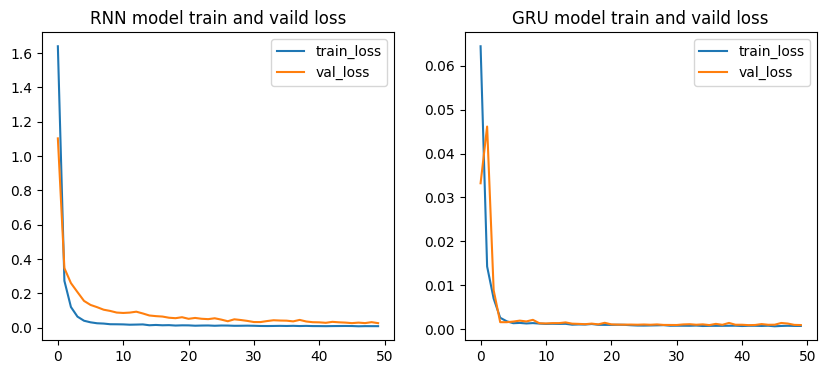

In [16]:
fg, ax =plt.subplots(1,2,figsize=(10,4))
ax[0].plot(RNNhistory.history['loss'], label='train_loss')
ax[0].plot(RNNhistory.history['val_loss'], label='val_loss')
ax[0].set_title('RNN model train and vaild loss')
ax[0].legend()

ax[1].plot(GRUhistory.history['loss'], label='train_loss')
ax[1].plot(GRUhistory.history['val_loss'], label='val_loss')
ax[1].set_title('GRU model train and vaild loss')
ax[1].legend()

fg.show()

In [17]:
RNNtest_predicted = RNNmodel.predict(test_seq_rnn)

# Inversing scaling on predicted data
test_inverse_label_rnn = SS.inverse_transform(test_label_rnn)
RNNtest_inverse_predicted = SS.inverse_transform(RNNtest_predicted) 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [18]:
GRUtest_predicted = GRUmodel.predict(test_seq_gru)

# Inversing scaling on predicted data
test_inverse_label_gru = MMS.inverse_transform(test_label_gru)
GRUtest_inverse_predicted = MMS.inverse_transform(GRUtest_predicted) 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


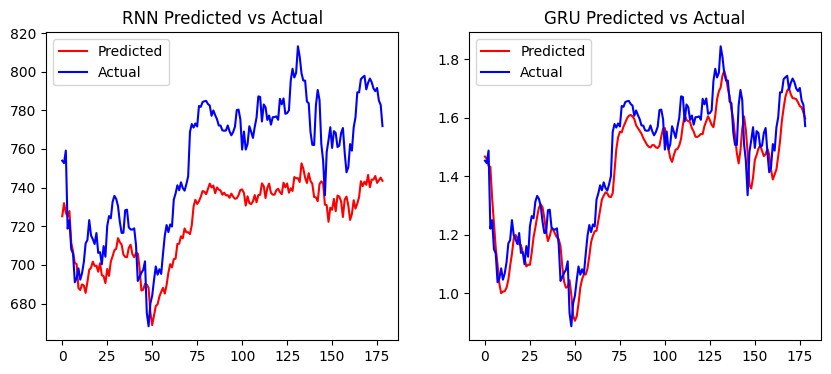

In [19]:
fg, ax =plt.subplots(1,2,figsize=(10,4))
ax[0].plot(RNNtest_inverse_predicted, label='Predicted', color='red')
ax[0].plot(test_inverse_label_rnn, label='Actual', color='blue')
ax[0].set_title('RNN Predicted vs Actual')
ax[0].legend()

ax[1].plot(GRUtest_inverse_predicted, label='Predicted', color='red')
ax[1].plot(test_inverse_label_gru, label='Actual', color='blue')
ax[1].set_title('GRU Predicted vs Actual')
ax[1].legend()

fg.show()